In [1]:
from functools import reduce

from cycler import cycler
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
#from scipy import stats as sstats
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt

import gspread
from google.oauth2.service_account import Credentials

In [2]:
%matplotlib inline
wmf.charting.set_mpl_style()

In [3]:
FILE = "metrics/metrics.tsv"
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

FILE_D =  "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(FILE_D, sep="\t", parse_dates=["month"]).set_index("month")

graph_end = metrics.index[-1]
graph_start = graph_end - relativedelta(months = 47)
prior_month = graph_end- relativedelta(months = 1)

# Data transformation

In [4]:
# Transform content flows into content stocks
def stock_to_flow(arr):
    return arr[-1] - arr[0]

flow_cols = [
    "net_new_content_pages", 
    "net_new_Wikipedia_articles", 
    "net_new_Commons_content_pages", 
    "net_new_Wikidata_entities"
]
stock_cols = [
    "content_pages", 
    "Wikipedia_articles", 
    "Commons_content_pages",
    "Wikidata_entities"
]

name_map = {flow_cols[i]: stock_cols[i] for i in range(len(stock_cols))}

stock_metrics = metrics[flow_cols].cumsum().rename(name_map, axis=1)

metrics = pd.concat([metrics, stock_metrics], axis=1)

In [5]:
metrics_all = pd.concat([metrics, diversity_metrics], axis=1)
metrics_all  = metrics_all.loc[:,~metrics_all.columns.duplicated()]

# Report

In [6]:
report_order = [
     #Editors
    'month',
    'active_editors',
        'new_active_editors',
        'returning_active_editors',
    'new_editor_retention',
    # Content
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
        'anonymous_edits',
        'non_anonymous_edits',
    #Diversity Content
    'global_north_net_new_content',
    'global_south_net_new_content',
    'global_north_edits',
    'global_south_edits',
    #Diversity Editors
    'global_north_active_editors',
    'global_south_active_editors',
    #'global_north_new_editor_retention',
    #'global_south_new_editor_retention'

]

In [7]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def calc_rpt(ser):   
    cur = ser[-1]
    
    try:
        yr_prev = ser[-13]
        yoy_value = yr_prev 
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
        
    try:
        yoyoyoy_value = ser[-37]
        cagr_change = (cur  / yoyoyoy_value)**(1/4) - 1
        yoyoyoy = (cur / yoyoyoy_value) - 1
    except IndexError:
        cagr = None
        
    
    res = [cur, yoy_change, yoy_value, yoyoyoy, yoyoyoy_value, cagr_change]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["value", "yoy_change", "yoy_value", "yoyoyoy", "yoyoyoy_value", "3_yr_cagr"]
    )



#TODO Fix lines below, ensure the logic mirrors the logic updated in calc_rpt
def calc_prev_month_rpt(ser):   
    pm_cur = ser[-2]
    
    try:
        pm_yr_prev = ser[-14]
        pm_yoy_change = (pm_cur / pm_yr_prev) - 1
    except IndexError:
        pm_yoy_change = None
        
    try:
        pm_cagr = (ser[-2] / ser[-49])**(1/4) - 1
    except IndexError:
        pm_cagr = None
        
    
    pm_res = [pm_cur, pm_yoy_change, pm_cagr]
    return pd.Series(
        [fmt_num(n) for n in pm_res],
        index=["previous_M_value", "PM_yoy_change", "PM4_yr_cagr"]
    )

In [8]:
#TODO have month appear in the values below, first row
print("Monthly report", )
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
    #.fillna("—")
)

Monthly report


,value,yoy_change,yoy_value,yoyoyoy,yoyoyoy_value,3_yr_cagr
month,NaN,NaN,NaN,NaN,NaN,NaN
active_editors,"87,000",-2.1%,"88,900",4.6%,"83,200",1.1%
new_active_editors,"16,000",-6.1%,"17,000",-5.2%,"16,900",-1.3%
returning_active_editors,"71,000",-1.2%,"71,900",7.1%,"66,300",1.7%
new_editor_retention,6.5%,3.7%,6.3%,12.2%,5.8%,2.9%
content_pages,"310,000,000",7.2%,"289,000,000",42.5%,"217,000,000",9.2%
Wikipedia_articles,"61,800,000",5.0%,"58,900,000",20.0%,"51,500,000",4.7%
Commons_content_pages,"88,200,000",12.9%,"78,100,000",55.5%,"56,700,000",11.7%
Wikidata_entities,"102,000,000",5.0%,"96,900,000",63.0%,"62,400,000",13.0%
net_new_content_pages,"2,020,000",19.8%,"1,680,000",-44.2%,"3,620,000",-13.6%


In [9]:
print("Previous month's report")
(
    metrics_all
    .apply(calc_prev_month_rpt)
    .transpose()
    .reindex(report_order)
    .fillna("—")
)

Previous month's report


,previous_M_value,PM_yoy_change,PM4_yr_cagr
month,—,—,—
active_editors,"88,000",-2.5%,1.7%
new_active_editors,"15,800",-2.9%,-3.5%
returning_active_editors,"72,200",-2.4%,3.0%
new_editor_retention,6.0%,-0.2%,1.5%
content_pages,"308,000,000",7.2%,12.4%
Wikipedia_articles,"61,500,000",4.9%,5.9%
Commons_content_pages,"87,400,000",13.0%,15.0%
Wikidata_entities,"101,000,000",4.8%,19.0%
net_new_content_pages,"1,690,000",-27.6%,0.8%


# Graphs

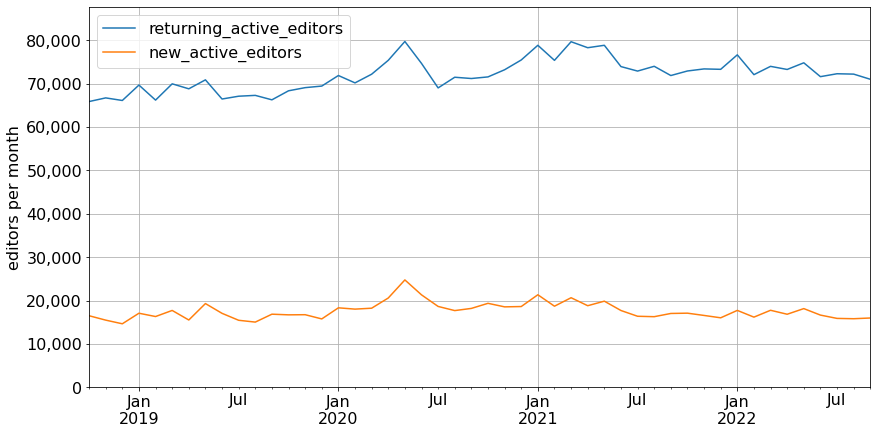

In [10]:
ax = metrics[["returning_active_editors", "new_active_editors"]][graph_start:graph_end].plot()
plt.gca().yaxis.set_major_formatter(comma_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("editors per month");

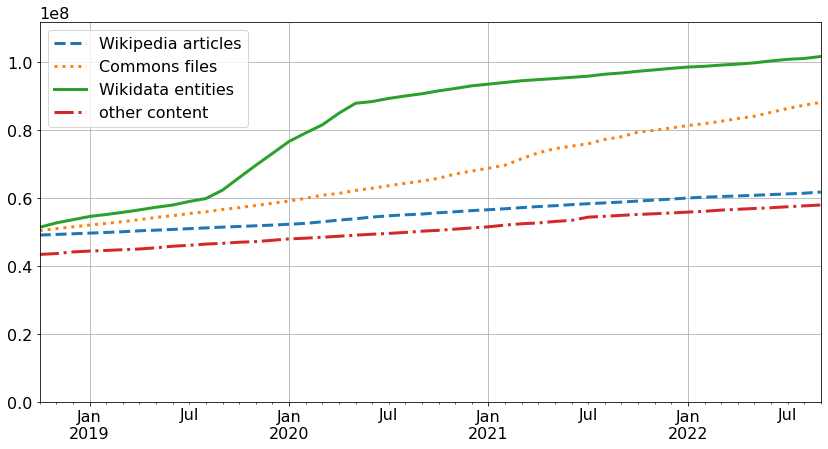

In [11]:
custom_cyc = cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['-', '--', ':', '-.'])
content_types = metrics[["Wikipedia_articles", "Commons_content_pages", "Wikidata_entities"]]
content_ser = [tup[1] for tup in content_types.iteritems()]

other_content = reduce(lambda x, y: x - y, content_ser, metrics["content_pages"]).rename("other_content")
content = pd.concat(
    [content_types, other_content], 
    axis=1
).rename(
    columns=lambda name: name.replace("_", " ")
).rename(
    columns={"Commons content pages": "Commons files"}
)

ax.set_prop_cycle(custom_cyc)
ax = content[graph_start:graph_end].plot(style=['--', ':', '-', '-.'], linewidth=3)

#ax.yaxis.set_major_formatter(M_fmt)
#--removed "ax.yaxis.set_major_formatter(M_fmt)" as a workaround to the error "M_str() takes 1 positional argument but 2 were given" that we encountered while running this notebok
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("");

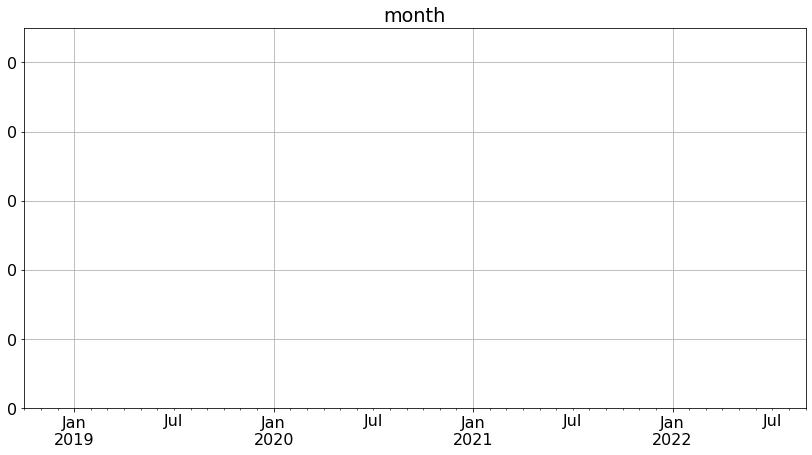

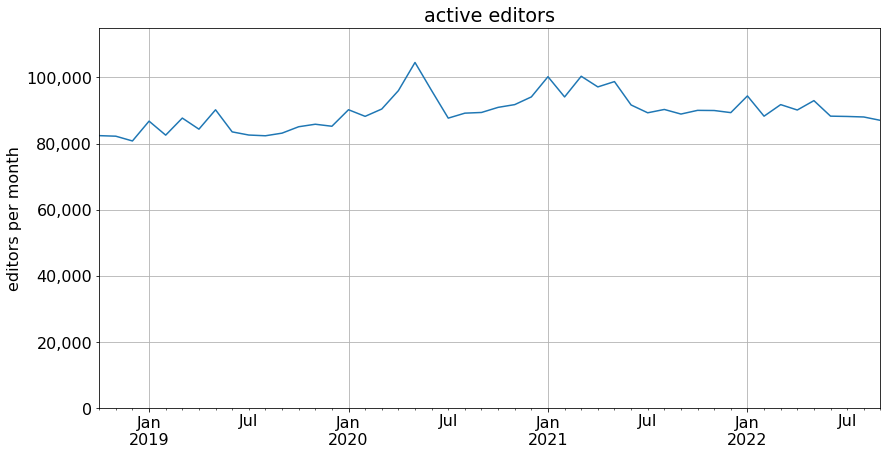

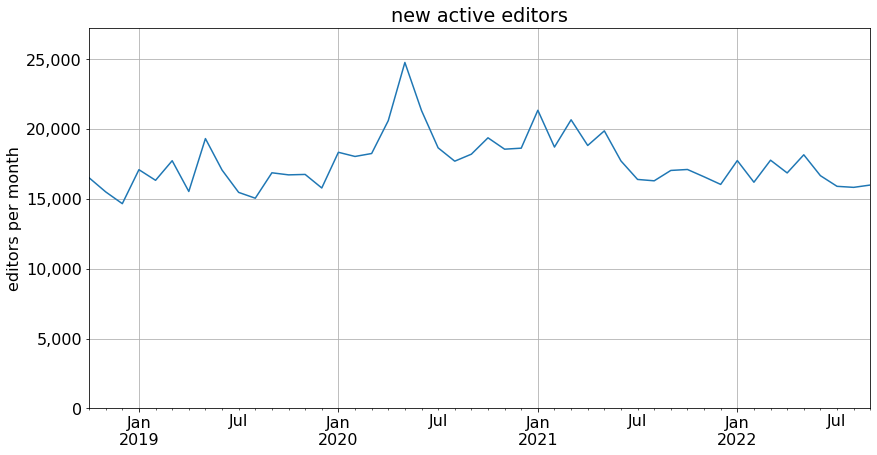

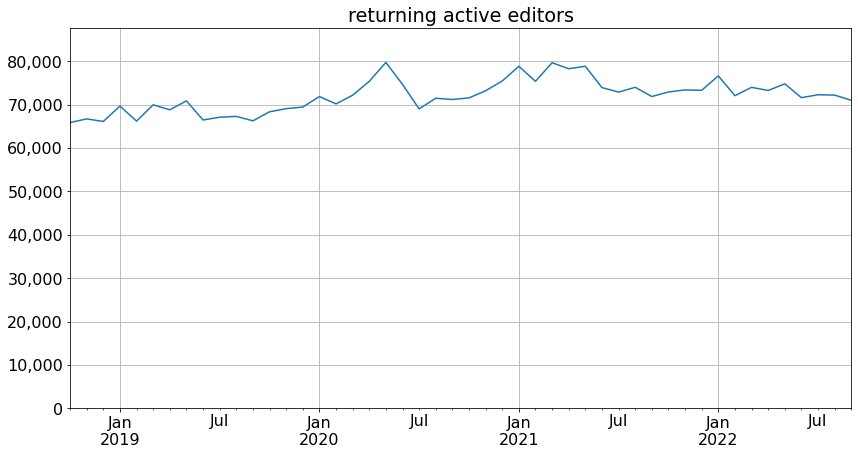

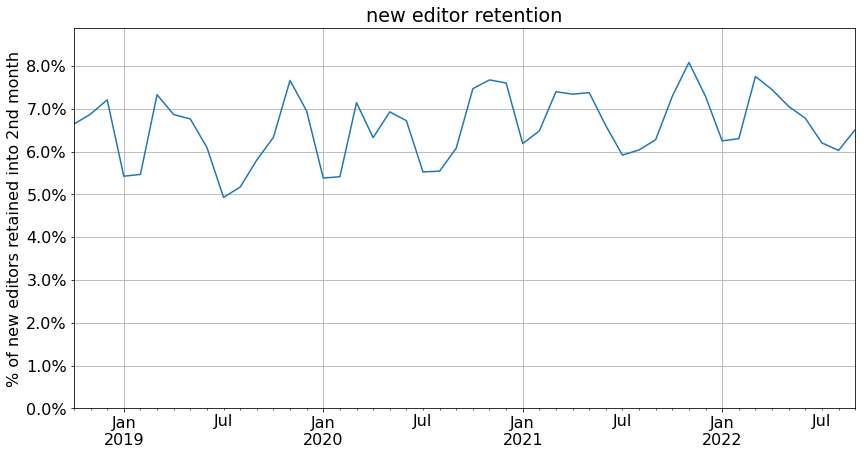

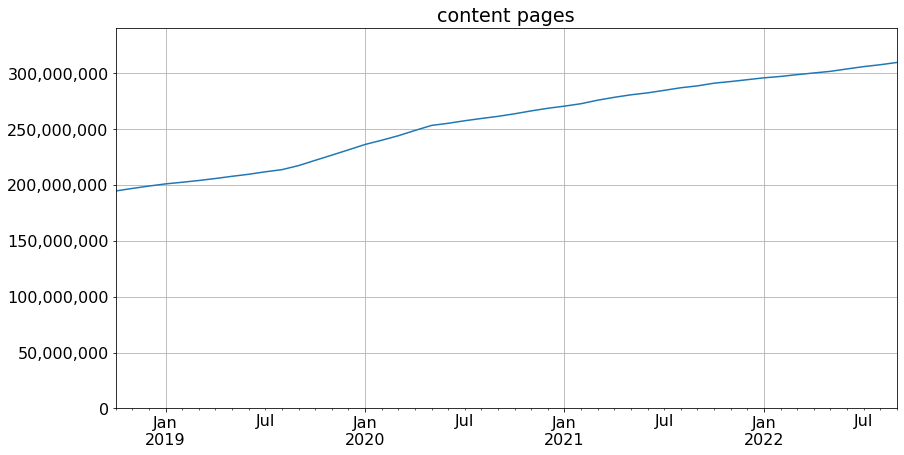

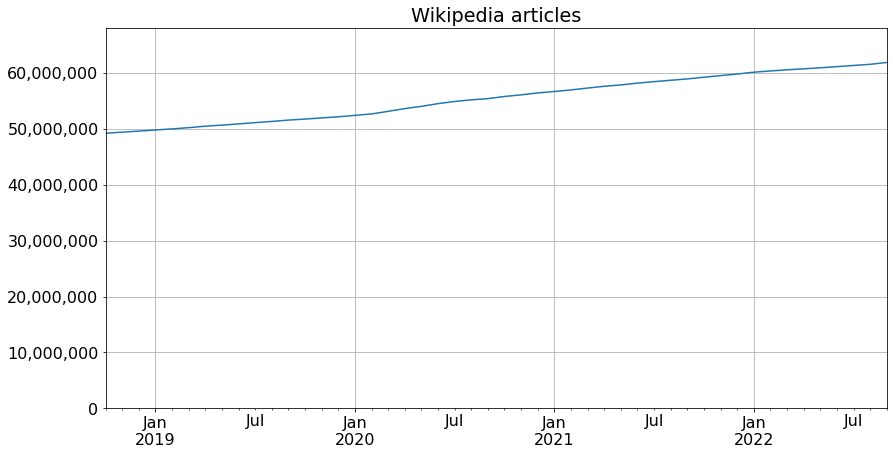

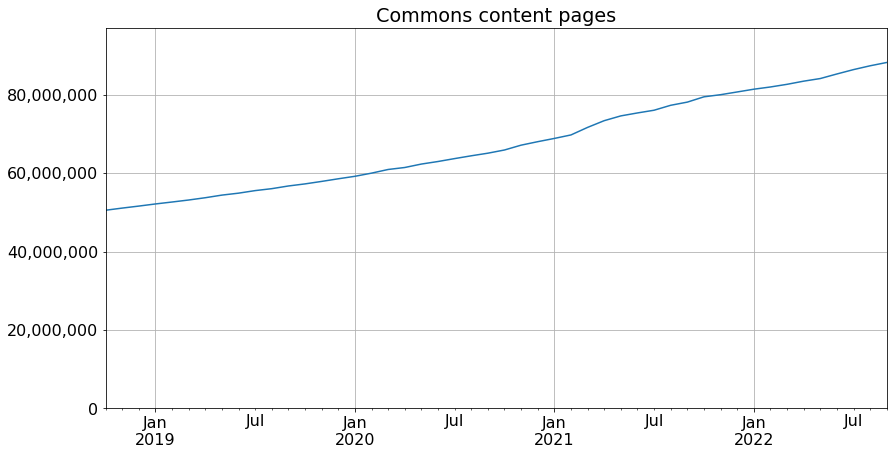

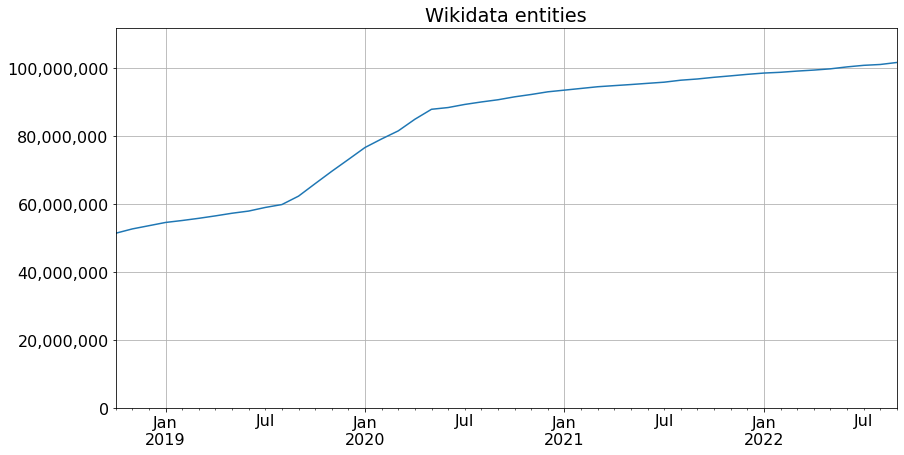

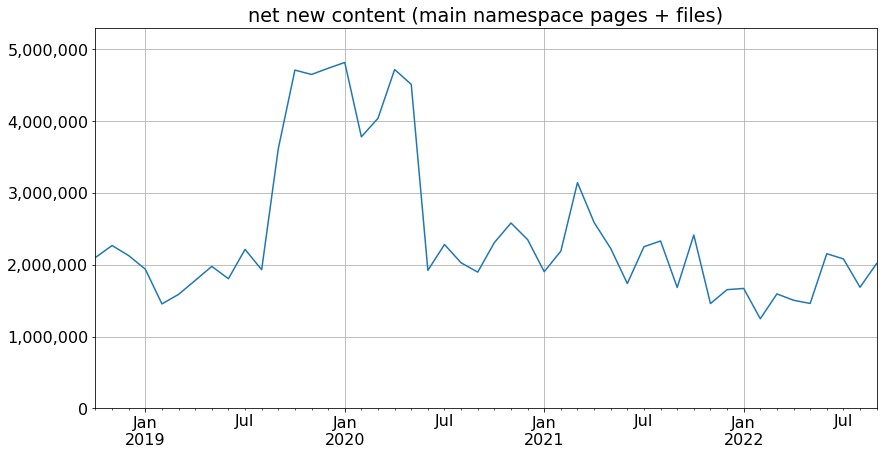

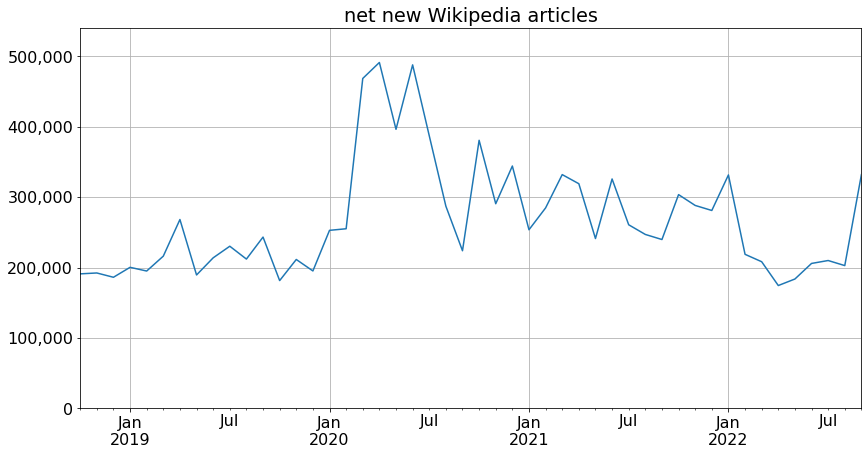

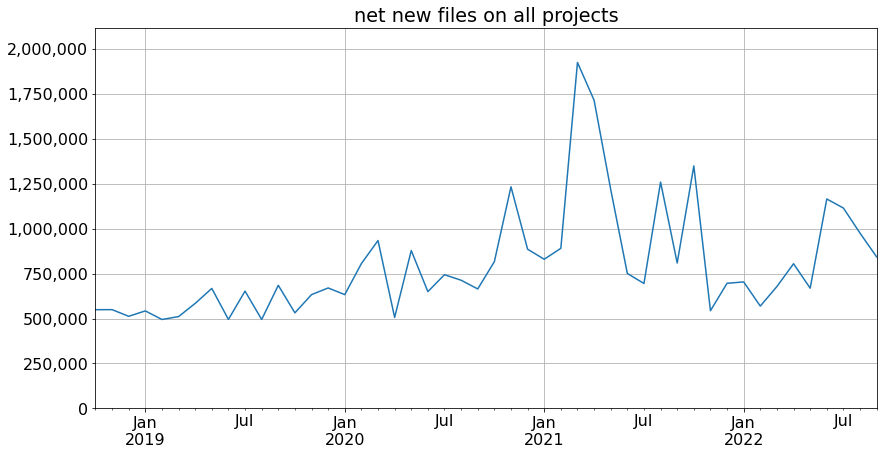

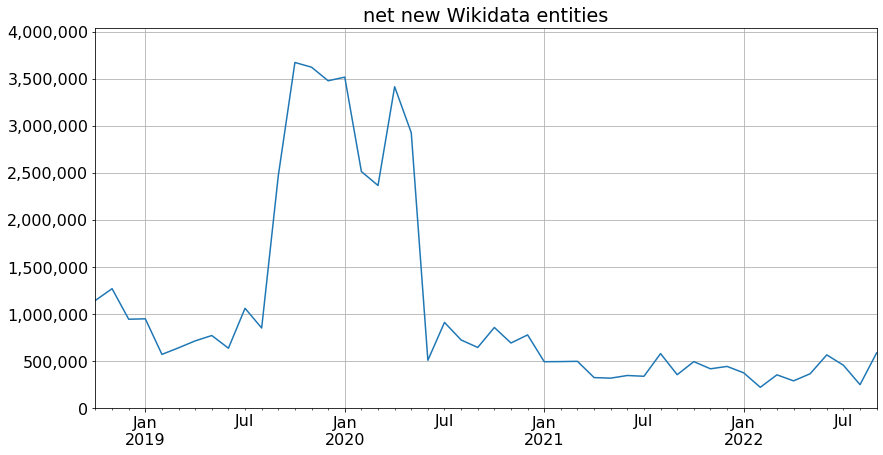

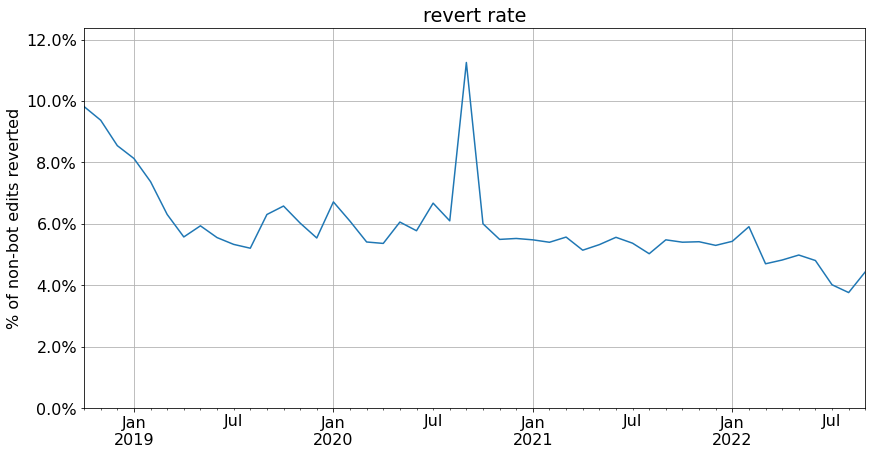

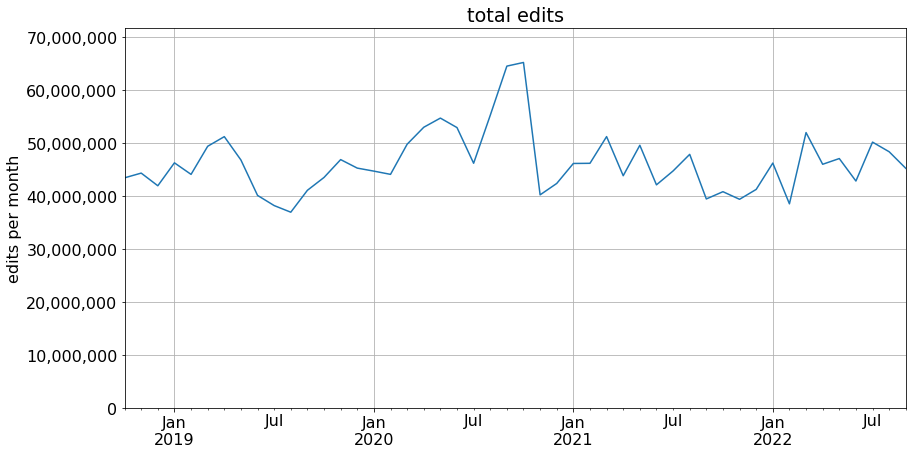

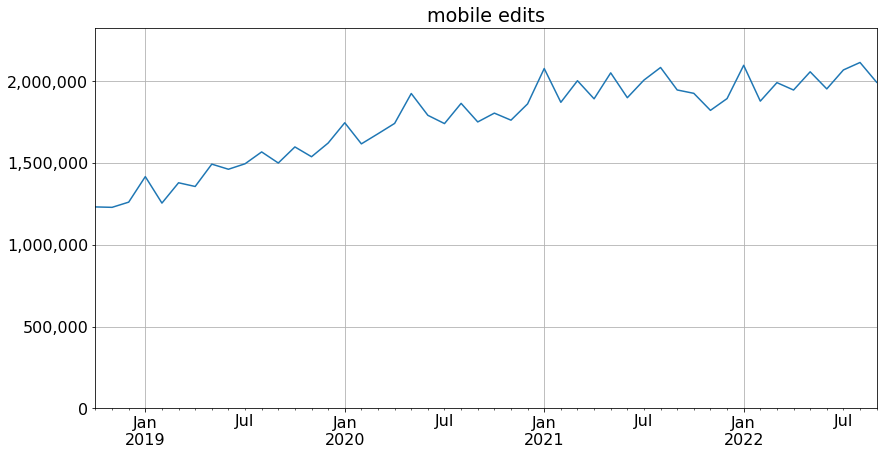

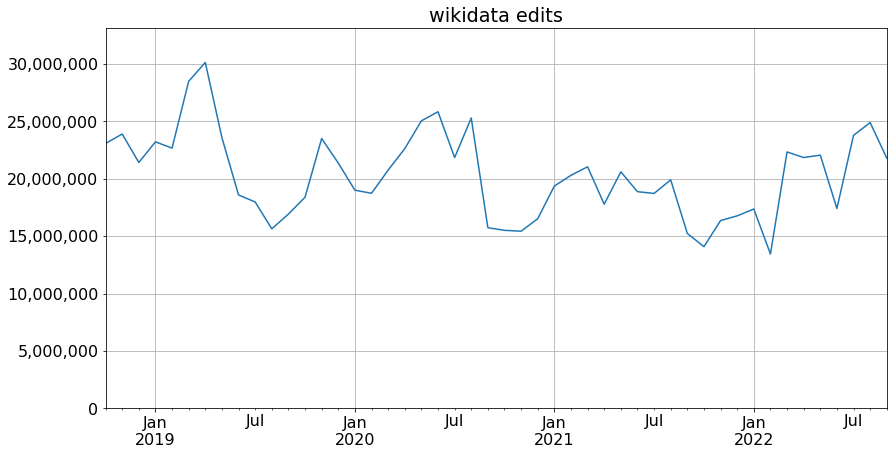

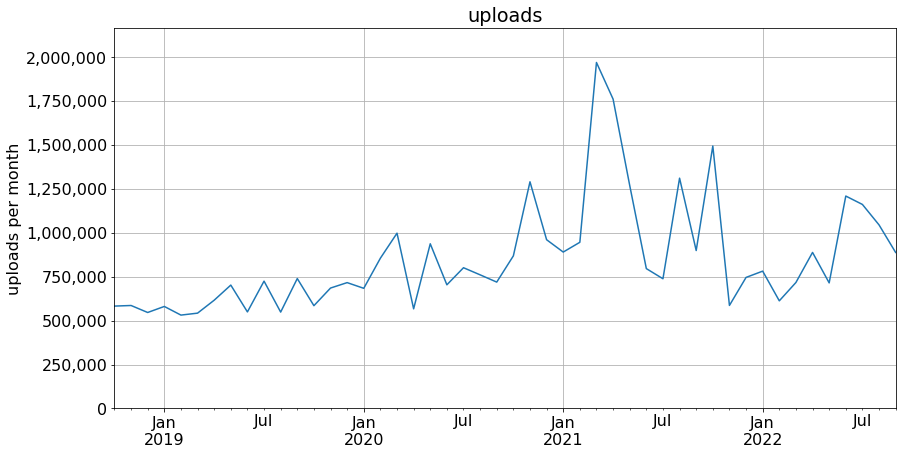

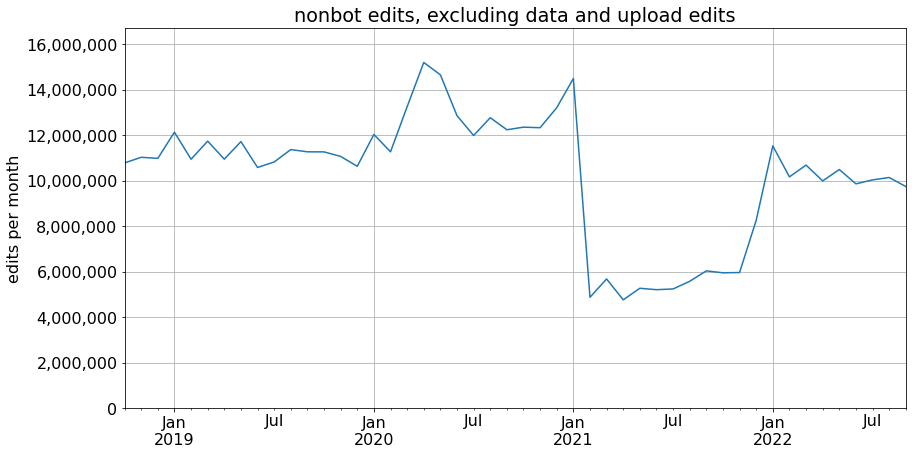

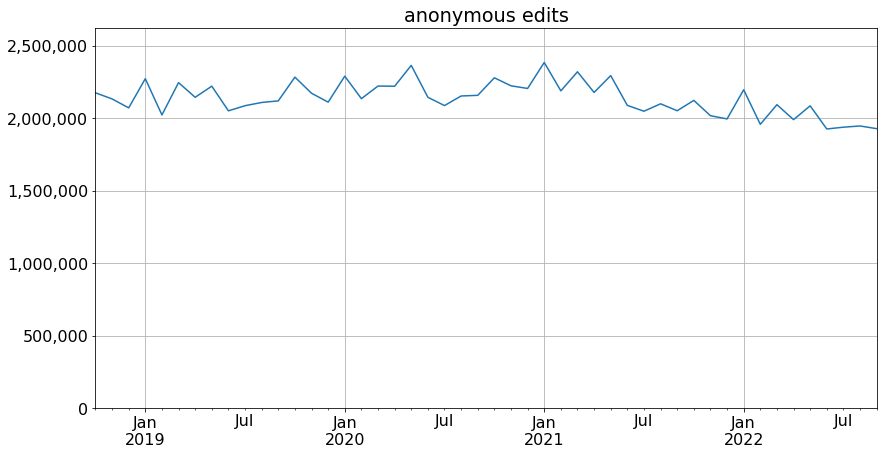

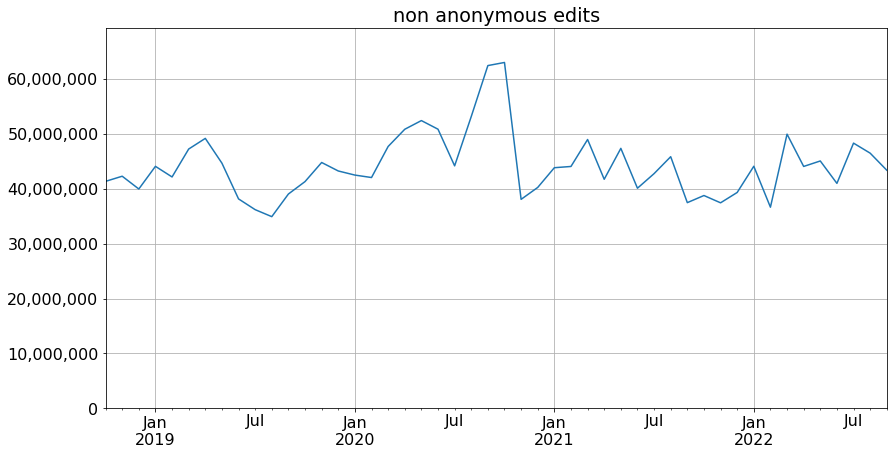

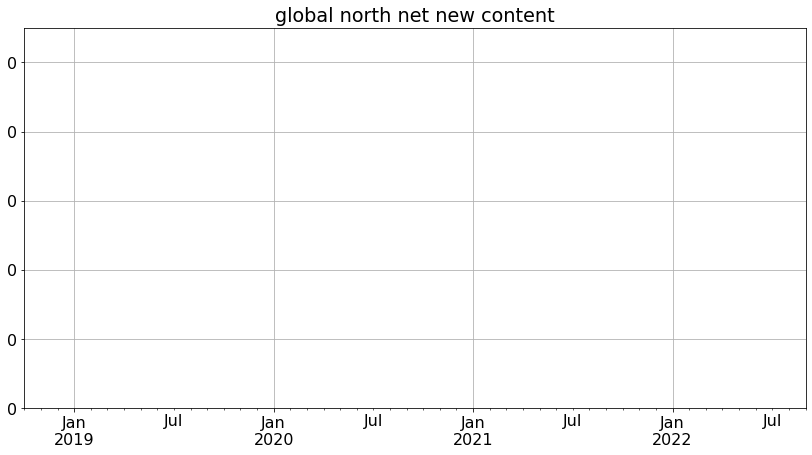

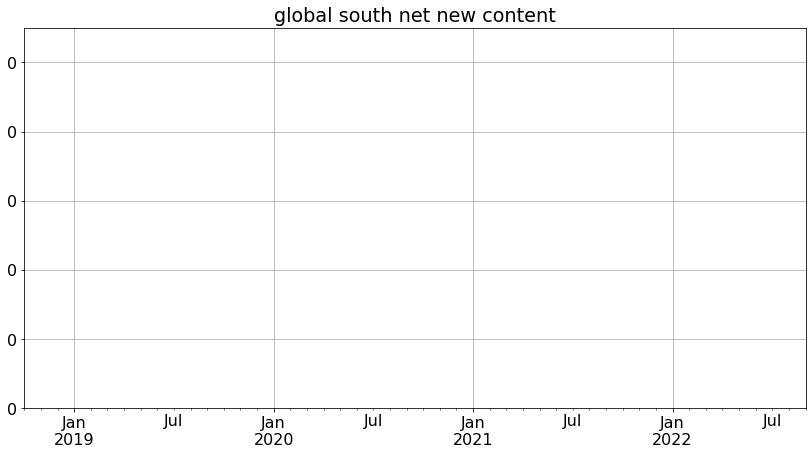

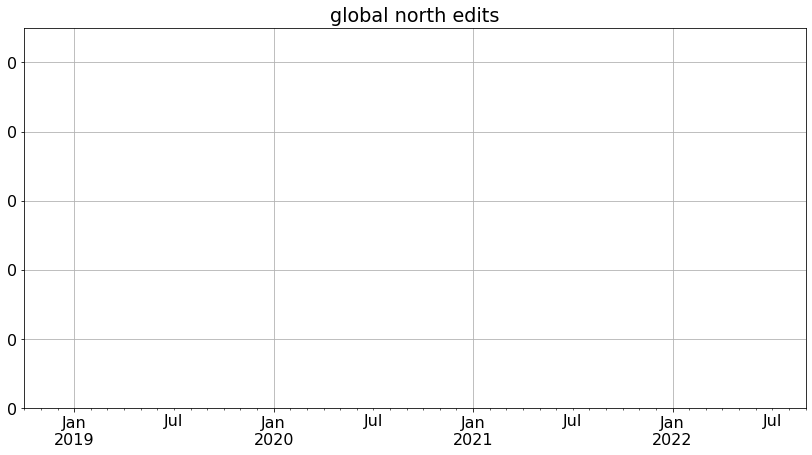

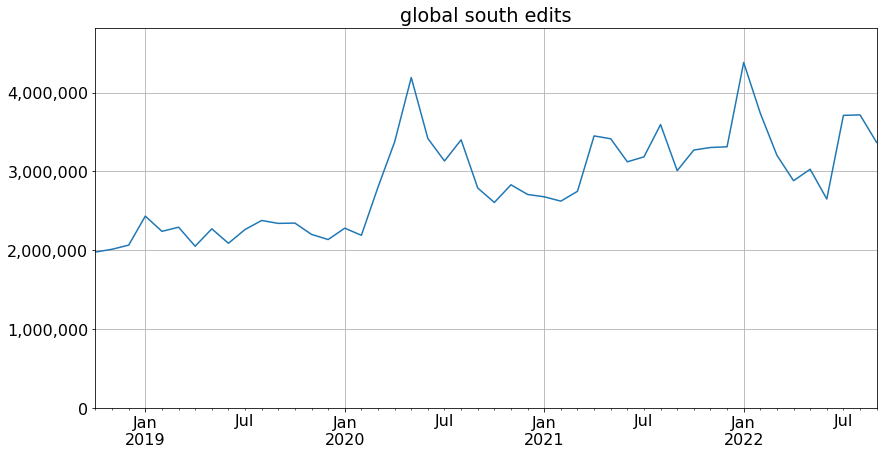

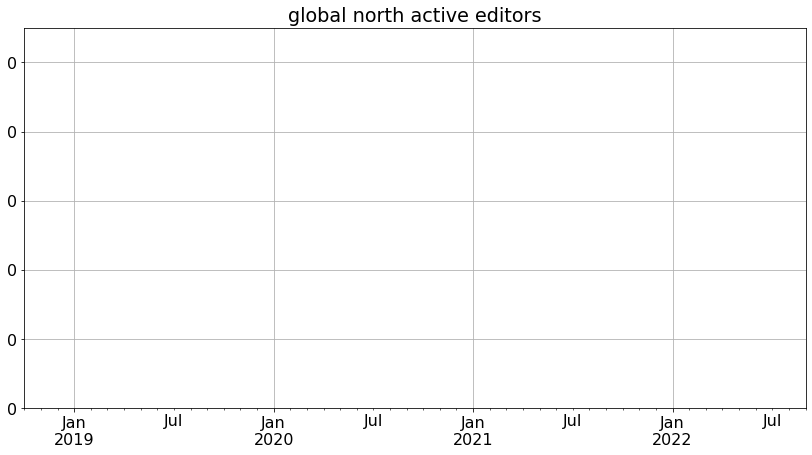

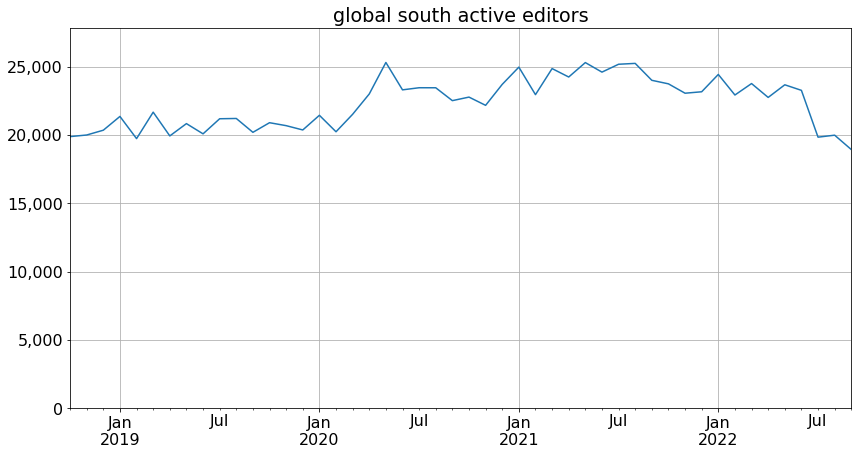

In [12]:
graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "content_pages": {
      #  "y_fmt": M_fmt,
        # removed M_Fmt from graph_cfg as a workaround for the error "M_str() takes 1 positional argument but 2 were given"
    },
    "Wikipedia_articles": {
       # "y_fmt": M_fmt,
    },
    "Wikidata_entities": {
       # "y_fmt": M_fmt,
    },
    "Commons_content_pages": {
       # "y_fmt": M_fmt,
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
       # "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
   
    "other_nonbot_edits": {
       # "y_fmt": M_fmt,
        "y_lab": "edits per month",
        "title": "nonbot edits, excluding data and upload edits"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    },
    "revert_rate": {
        "y_fmt": pct_fmt,
        "y_lab": "% of non-bot edits reverted"
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
      #  "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "net_new_content_pages": {
       # "y_fmt": M_fmt,
        "title": "net new content (main namespace pages + files)"
    },
    "net_new_Wikipedia_articles": {
    },
    "net_new_Commons_content_pages": {
        "title": "net new files on all projects"
    },
    "net_new_Wikidata_entities": {
    },
    "global_north_net_new_content": {
    },
    "global_south_net_new_content": {
    },
     "global_north_edits": {
    },
    "global_south_edits": {
    },
     "global_north_active_editors": {
    },
    "global_south_active_editors": {
    }
   # "global_south_new_editor_retention": {
   #     "y_fmt": pct_fmt,
   #     "y_lab": "% of new editors retained into 2nd month"
   # },
   # "global_north_new_editor_retention": {
   #     "y_fmt": pct_fmt,
   #     "y_lab": "% of new editors retained into 2nd month"
   # }    
}


    
    

for name, col in metrics.reindex(report_order, axis=1).iteritems():
    cfg = graph_cfg.get(name, {})
    plt.figure()
    
    col[graph_start:graph_end].plot()

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.xlabel("")
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
    
    y_top = plt.ylim()[1] * 1.1
    plt.ylim(bottom=0, top=y_top)
    plt.show()
    plt.close()

# Update Editors Google Sheet

In [13]:
FILE = "metrics/metrics.tsv"
all_metrics = pd.read_csv(FILE, sep="\t")


DIV_FILE = "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(DIV_FILE, sep="\t")

In [14]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('key-metrics-343717-07427b76df93.json', scopes=scope)
gc = gspread.authorize(credentials)

In [15]:
all_metrics.iloc[-1,1:] = all_metrics.iloc[-1,1:].astype(float)
diversity_metrics.iloc[-1,1:] = diversity_metrics.iloc[-1,1:].astype(float)

In [16]:
@property
def sheet1(self):
    """Shortcut property for getting the first worksheet."""
    return self.get_worksheet(0)

In [17]:
wks1 = gc.open("editors").sheet1
new_metrics = all_metrics.iloc[-1,[0,1,2,11,12,13,14,15,16,17,18,19,20,21,22,23,24]].tolist()
wks1.append_row(new_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'metrics!A1:Q263',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'metrics!A264:Q264',
  'updatedRows': 1,
  'updatedColumns': 17,
  'updatedCells': 17}}

In [18]:
# To address NaN values that may cause errors when moving the values to sheets
#Replace all np.nan values with python's None
diversity_metrics = diversity_metrics.where(pd.notnull(diversity_metrics), None)

In [19]:
#You need to change the datatype to object
diversity_metrics = diversity_metrics.astype(object).where(diversity_metrics.notna(), None)

#didn't work:
#diversity_metrics.where(diversity_metrics.notnull(), None)

In [20]:
wks2 = gc.open("editors").get_worksheet(1)
div_metrics = diversity_metrics.iloc[-1].tolist()
wks2.append_row(div_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_global_market!A1:M58',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_global_market!A59:M59',
  'updatedRows': 1,
  'updatedColumns': 11,
  'updatedCells': 11}}

In [21]:
wks3 = gc.open("editors").get_worksheet(2)
mh_metrics = all_metrics.iloc[-1,[0,6,7,8,9]].tolist()
wks3.append_row(mh_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_mobile_heavy!A1:E261',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_mobile_heavy!A262:E262',
  'updatedRows': 1,
  'updatedColumns': 5,
  'updatedCells': 5}}